In [1]:
#!pip install --upgrade pip setuptools wheel
!pip install git+https://github.com/HumanCompatibleAI/overcooked_ai.git
!pip install Pillow
!pip install matplotlib
!pip install IPython
!pip install torch

  Cloning https://github.com/HumanCompatibleAI/overcooked_ai.git to /tmp/pip-req-build-ecmt9cfu
  Running command git clone --filter=blob:none --quiet https://github.com/HumanCompatibleAI/overcooked_ai.git /tmp/pip-req-build-ecmt9cfu
  Resolved https://github.com/HumanCompatibleAI/overcooked_ai.git to commit 83f51921869f25ddf5153aa2742b4e1d4da5e6e9
  Preparing metadata (setup.py) ... done


In [2]:
### Imports ###

from overcooked_ai_py.mdp.overcooked_mdp import OvercookedGridworld
from overcooked_ai_py.mdp.overcooked_env import OvercookedEnv
from overcooked_ai_py.agents.benchmarking import AgentEvaluator
from overcooked_ai_py.visualization.state_visualizer import StateVisualizer
from overcooked_ai_py.agents.agent import NNPolicy, AgentFromPolicy, AgentPair
import gym
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import display, HTML

import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import pdb
import os
from IPython.display import display, Image as IPImage
import torch.nn.functional as F

In [3]:
# Project 2 Deep SARSA
# We modify it to be DQN because it makes more sense to be off-policy
# Adding an experience buffer to be more efficient with episodes
import copy
class NN(nn.Module):
    def __init__(self, hidden_size1, hidden_size2):
        super(NN, self).__init__()
        if hidden_size2 > 0:
            self.network = nn.Sequential(
                nn.Linear(96, hidden_size1),
                nn.ReLU(),
                nn.Linear(hidden_size1, hidden_size2),
                nn.ReLU(),
                nn.Linear(hidden_size2, 6))
        else:
            self.network = nn.Sequential(
                nn.Linear(96, hidden_size1),
                nn.ReLU(),
                nn.Linear(hidden_size1, 6))

    def forward(self, x):
        return self.network(x)

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state0, state1, action0, action1, reward0, reward1, next_state0, next_state1, done):
        self.buffer.append((state0, state1, action0, action1, reward0, reward1, next_state0, next_state1, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

class VDNAgent(object):
    def __init__(self, env, max_iter=1000, reporting_interval=50,
                 alpha=0.05, alpha_decay=0.999, min_alpha=0.001,
                 gamma=0.99, tau=0.001,
                 epsilon=1.0, epsilon_decay=0.999, min_epsilon=0.01,
                 hidden_size1=128, hidden_size2=0,
                 buffer_size=10000, batch_size=64):

        self.gamma = gamma
        self.env = env
        self.max_iter = max_iter
        self.reporting_interval = reporting_interval

        # alpha params
        self.alpha=alpha
        self.alpha_decay = alpha_decay
        self.min_alpha = min_alpha

        # epsilon params
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon

        # metrics
        self.tot_rewards = []
        self.soups_made = []
        self.soups_pickedup = []
        self.dishes_dropped = []

        # replay buffers, one for each agent
        self.replay_buffer0 = ReplayBuffer(buffer_size)
        self.batch_size = batch_size

        # NN params
        self.q_network0 = NN(hidden_size1, hidden_size2)
        self.target_network0 = NN(hidden_size1, hidden_size2)
        self.target_network0.load_state_dict(self.q_network0.state_dict())

        self.q_network1 = NN(hidden_size1, hidden_size2)
        self.target_network1 = NN(hidden_size1, hidden_size2)
        self.target_network1.load_state_dict(self.q_network1.state_dict())

        self.optimizer0 = optim.Adam(self.q_network0.parameters(), lr=alpha)
        self.optimizer1 = optim.Adam(self.q_network1.parameters(), lr=alpha)
        self.tau = tau

        self.best_network0 = self.q_network0
        self.best_network1 = self.q_network1


    def solve(self):
        iters = 0
        converged = False
        torch.manual_seed(3)
        np.random.seed(3)
        while iters < self.max_iter:
            done = False
            num_soups_made = 0
            tot_reward = 0
            state = self.env.reset()
            old_stats = self.env.base_env.game_stats.copy()
            while not done:
                state0 = state['both_agent_obs'][0]
                state1 = state['both_agent_obs'][1]
                a0 = self.next_move(state0, 0)
                a1 = self.next_move(state1, 1)

                new_state, reward, done, info = self.env.step([a0,a1])


                # adding up rewards

                if env.agent_idx == 0:
                    agent_0_reward = info["sparse_r_by_agent"][0] + info["shaped_r_by_agent"][0]
                    agent_1_reward = info["sparse_r_by_agent"][1] + info["shaped_r_by_agent"][1]
                else:
                    agent_0_reward = info["sparse_r_by_agent"][1] + info["shaped_r_by_agent"][1]
                    agent_1_reward = info["sparse_r_by_agent"][0] + info["shaped_r_by_agent"][0]

                new_stats = self.env.base_env.game_stats.copy()
                agent_0_reward += self.shaped_reward(state, new_state, old_stats, new_stats)
                agent_1_reward += self.shaped_reward(state, new_state, old_stats, new_stats)

                num_soups_made += int(reward / 20) # rewards are totaled

                tot_reward += agent_0_reward + agent_1_reward
                new_state0 = new_state['both_agent_obs'][0]
                new_state1 = new_state['both_agent_obs'][1]

                self.replay_buffer0.push(state0, state1, a0, a1, agent_0_reward, agent_1_reward, new_state0, new_state1, done)

                if len(self.replay_buffer0) > self.batch_size:
                    experiences = self.replay_buffer0.sample(self.batch_size)
                    self.learn_network(experiences, 0)
                    self.learn_network(experiences, 1)
                state = new_state
                old_stats = copy.deepcopy(self.env.base_env.game_stats)
            iters += 1

            # stats
            self.soups_made.append(num_soups_made)
            self.tot_rewards.append(tot_reward)
            stats_list1 = info['episode']['ep_game_stats']['dish_drop']
            stats_list2 = info['episode']['ep_game_stats']['soup_pickup']
            total1 = 0
            total2 = 0
            for stats in stats_list1:
                 total1 += len(stats)
            for stats in stats_list2:
                 total2 += len(stats)
            self.dishes_dropped.append(total1)
            self.soups_pickedup.append(total2)

            # save best params
            if num_soups_made >= max(self.soups_made):
                torch.save(self.q_network0.state_dict(), 'best_network0.pth')
                torch.save(self.q_network1.state_dict(), 'best_network1.pth')


            # decay epsilon
            self.epsilon = max(self.epsilon_decay * self.epsilon, self.min_epsilon)
            # decay alpha
            self.alpha = max(self.alpha_decay * self.alpha, self.min_alpha)
            self.optimizer0.param_groups[0]['lr'] = self.alpha
            self.optimizer1.param_groups[0]['lr'] = self.alpha

            # update on training
            if iters % self.reporting_interval == 0:
                print('finished ', iters ,' iterations', 'made soups: ', np.mean(self.soups_made[-self.reporting_interval:]))
                print('tot reward:', np.mean(self.tot_rewards[-self.reporting_interval:]))
                print('current epsilon', self.epsilon)
            if iters % 1000 == 0:
                plt.plot(self.tot_rewards)
                plt.ylabel('Episode Reward')
                plt.xlabel('Episodes')
                plt.show()


    def next_move(self, state, index):
        ''' returns epsilon greedy move given an np.array state'''
        state = torch.FloatTensor(state).unsqueeze(0)
        if index == 0:
            # set the action based on epsilon greedy
            if np.random.random() < self.epsilon:
                return(self.env.action_space.sample())
            else:
                # calculate the argmax using torch
                with torch.no_grad():
                    q_values = self.q_network0(state)
                    return(torch.argmax(q_values).item())
        elif index == 1:
            if np.random.random() < self.epsilon:
                return(self.env.action_space.sample())
            else:
                # calculate the argmax using torch
                with torch.no_grad():
                    q_values = self.q_network1(state)
                    return(torch.argmax(q_values).item())
        else:
            raise ValueError('index must be 0 or 1')

    def optimal_move(self, state, index):
        ''' return optimal next move given an np.array state'''
        if index == 0:
            with torch.no_grad():
                q_values = self.q_network0(state)
                return(torch.argmax(q_values).item())
        elif index == 1:
            with torch.no_grad():
                q_values = self.q_network1(state)
                return(torch.argmax(q_values).item())
        else:
            raise ValueError('index must be 0 or 1')

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

    def learn_network(self, experiences, index):
        states0, states1, actions0, actions1, rewards0, rewards1, next_states0, next_states1, dones = zip(*experiences)
        states0 = torch.FloatTensor(np.array(states0))
        states1 = torch.FloatTensor(np.array(states1))
        actions0 = torch.LongTensor(actions0)
        actions1 = torch.LongTensor(actions1)
        rewards0 = torch.FloatTensor(rewards0)
        rewards1 = torch.FloatTensor(rewards1)
        next_states0 = torch.FloatTensor(np.array(next_states0))
        next_states1 = torch.FloatTensor(np.array(next_states1))
        dones = torch.BoolTensor(dones)

        # compute q values for each q network
        current_q_values = self.q_network0(states0).gather(1, actions0.unsqueeze(1)).squeeze(1) + self.q_network1(states1).gather(1, actions1.unsqueeze(1)).squeeze(1)
        next_q_values = self.target_network0(next_states0).detach().max(1)[0] + self.target_network1(next_states1).detach().max(1)[0]
        next_q_values[dones] = 0

        target_q_values = rewards0 + rewards1 + self.gamma * next_q_values

        loss = F.mse_loss(current_q_values, target_q_values)
        self.optimizer0.zero_grad()
        self.optimizer1.zero_grad()
        loss.backward()
        self.optimizer0.step()
        self.optimizer1.step()
        self.soft_update(self.q_network0, self.target_network0, self.tau)
        self.soft_update(self.q_network1, self.target_network1, self.tau)

    def shaped_reward(self, old_state, new_state, old_stats, new_stats):
        # reward shaping based on states
        reward = 0
        reward += 3*soups_3onion_start(old_state, new_state) # good start
        reward += -3*soups_sub3onion_start(old_state, new_state) # bad start

        # small rewards for positive
        reward += 0.05*compare_stats(old_stats, new_stats, 'useful_onion_pickup')
        reward += 0.05*compare_stats(old_stats, new_stats, 'useful_dish_pickup')
        reward += 0.05*compare_stats(old_stats, new_stats, 'useful_onion_drop')
        reward += 0.05*compare_stats(old_stats, new_stats, 'useful_dish_drop')
        reward += -1*compare_stats(old_stats, new_stats, 'soup_drop')
        reward += 0.5*compare_stats(old_stats, new_stats, 'viable_onion_potting')

        return reward

def soups_3onion_cooking(state):
    out = 0
    all_soups = state['overcooked_state'].all_objects_by_type['soup']
    for soup in all_soups:
        if len(soup.ingredients) == 3 and soup.is_cooking:
            out += 1
    return out

def soups_sub3onion_cooking(state):
    out = 0
    all_soups = state['overcooked_state'].all_objects_by_type['soup']
    for soup in all_soups:
        if len(soup.ingredients) < 3 and soup.is_cooking:
            out += 1
    return out

def soups_3onion_start(old_state, new_state):
    if soups_3onion_cooking(new_state) > soups_3onion_cooking(old_state):
        return 1
    return 0

def soups_sub3onion_start(old_state, new_state):
    if soups_sub3onion_cooking(new_state) > soups_sub3onion_cooking(old_state):
        return 1
    return 0

def compare_stats(old_stats, new_stats, name):
    old_list = old_stats[name]
    new_list = new_stats[name]
    out = len(new_list[0]) + len(new_list[1]) - len(old_list[0]) - len(old_list[1])
    return out

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
### Environment setup ###

# Swap between the 5 layouts here:
# layout = "cramped_room"
# layout = "asymmetric_advantages"
# layout = "coordination_ring"
layout = "forced_coordination"
# layout = "counter_circuit_o_1order"

# Reward shaping is disabled by default.  This data structure may be used for
# reward shaping.  You can, of course, do your own reward shaping in lieu of, or
# in addition to, using this structure.
reward_shaping = {
    "PLACEMENT_IN_POT_REW": 3,
    "DISH_PICKUP_REWARD": 3,
    "SOUP_PICKUP_REWARD": 5,

}

# Length of Episodes.  Do not modify for your submission!
# Modification will result in a grading penalty!
horizon = 400

# Build the environment.  Do not modify!
mdp = OvercookedGridworld.from_layout_name(layout, rew_shaping_params=reward_shaping)
base_env = OvercookedEnv.from_mdp(mdp, horizon=horizon, info_level=0)
env = gym.make("Overcooked-v0", base_env=base_env, featurize_fn=base_env.featurize_state_mdp)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [7]:
a = VDNAgent(env, max_iter=5000, reporting_interval=250,
                 alpha=0.0001, alpha_decay=1, min_alpha=0.00001,
                 gamma=0.9, tau=0.001,
                 epsilon=1.0, epsilon_decay=0.998, min_epsilon=0.01,
                 hidden_size1=64, hidden_size2=0,
                 buffer_size=250000, batch_size=128)


Mounted at /content/gdrive


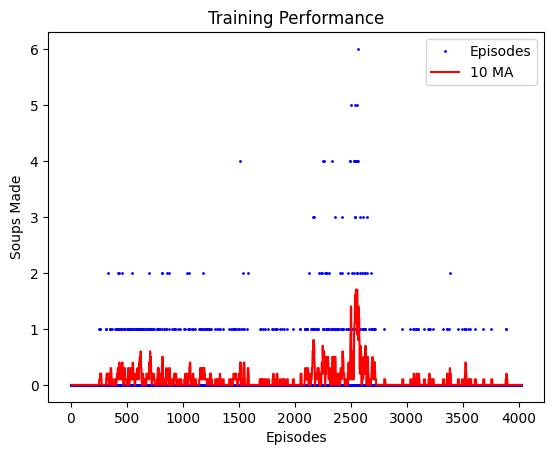

Avg rew: 0.00 (std: 0.00, se: 0.00); avg len: 400.00; : 100%|██████████| 1/1 [00:05<00:00,  5.36s/it]



len(trajs): 10


In [9]:
from google.colab import drive
import pandas as pd
drive.mount('/content/gdrive', force_remount=True)
images_dir = '/content/gdrive/My Drive/Colab_models'

#a.solve()

torch.save({'model_state_dict': a.q_network0.state_dict(),
            'optimizer_state_dict': a.optimizer0.state_dict()},
	          f"{images_dir}/model1_layout4.pth")

torch.save({'model_state_dict': a.q_network1.state_dict(),
            'optimizer_state_dict': a.optimizer1.state_dict()},
	          f"{images_dir}/model2_layout4.pth")

results_array = np.array(a.soups_made)
ma_amt = 10
ma10_array = np.convolve(results_array, np.ones(ma_amt)/ma_amt, mode='valid')
plt.plot(results_array, linestyle='', marker='o', markersize=1, label='Episodes', color='blue')
plt.plot(range(ma_amt,len(results_array)+1),ma10_array, color='red', label='10 MA')
plt.title('Training Performance')
plt.ylabel('Soups Made')
plt.xlabel('Episodes')
plt.legend()
images_dir = '/content/gdrive/My Drive/Colab_Images'
plt.savefig(f"{images_dir}/soups_layout4.png", dpi=300, format='png', bbox_inches='tight')
plt.show()

state_dict0 = torch.load('best_network0.pth')
state_dict1 = torch.load('best_network1.pth')
best_network0 = NN(64, 0)
best_network1 = NN(64, 0)

best_network0.load_state_dict(state_dict0)
best_network1.load_state_dict(state_dict1)

b = VDNAgent(env, max_iter=3000, reporting_interval=25,
                 alpha=0.00015, alpha_decay=0.999, min_alpha=0.00001,
                 gamma=0.9, tau=0.001,
                 epsilon=1.0, epsilon_decay=0.997, min_epsilon=0.01,
                 hidden_size1=64, hidden_size2=0,
                 buffer_size=250000, batch_size=256)


b.q_network0 = best_network0
b.q_network1 = best_network1


class StudentPolicy(NNPolicy):
    """ Generate policy """
    def __init__(self):
        super(StudentPolicy, self).__init__()

    def state_policy(self, state, agent_index):
        """
        This method should be used to generate the poiicy vector corresponding to
        the state and agent_index provided as input.  If you're using a neural
        network-based solution, the specifics depend on the algorithm you are using.
        Below are two commented examples, the first for a policy gradient algorithm
        and the second for a value-based algorithm.  In policy gradient algorithms,
        the neural networks output a policy directly.  In value-based algorithms,
        the policy must be derived from the Q value outputs of the networks.  The
        uncommented code below is a placeholder that generates a random policy.
        """
        featurized_state = base_env.featurize_state_mdp(state)
        input_state = torch.FloatTensor(featurized_state[agent_index]).unsqueeze(0)
        action = b.optimal_move(input_state, agent_index)
        action_probs = np.zeros(env.action_space.n)
        action_probs[action] = 1
        return action_probs

    def multi_state_policy(self, states, agent_indices):
        """ Generate a policy for a list of states and agent indices """
        return [self.state_policy(state, agent_index) for state, agent_index in zip(states, agent_indices)]


class StudentAgent(AgentFromPolicy):
    """Create an agent using the policy created by the class above"""
    def __init__(self, policy):
        super(StudentAgent, self).__init__(policy)


# Instantiate the policies for both agents
policy0 = StudentPolicy()
policy1 = StudentPolicy()

# Instantiate both agents
agent0 = StudentAgent(policy0)
agent1 = StudentAgent(policy1)
agent_pair = AgentPair(agent0, agent1)

# Generate an episode
ae = AgentEvaluator.from_layout_name({"layout_name": layout}, {"horizon": horizon})
trajs = ae.evaluate_agent_pair(agent_pair, num_games=1)
print("\nlen(trajs):", len(trajs))

img_dir = None
ipython_display = True
gif_path = None

pd.DataFrame(trajs['ep_returns']).to_csv(f"{images_dir}/soups_data_layout4.csv")
pd.DataFrame(a.dishes_dropped).to_csv(f"{images_dir}/dishes_dropped_layout4.csv")
pd.DataFrame(a.soups_pickedup).to_csv(f"{images_dir}/soups_pickedup_layout4.csv")


# Do not modify -- uncomment for GIF generation
#StateVisualizer().display_rendered_trajectory(trajs, img_directory_path=img_dir, ipython_display=ipython_display)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
images_dir = '/content/gdrive/My Drive/Colab_models'

torch.save({'model_state_dict': a.q_network0.state_dict(),
            'optimizer_state_dict': a.optimizer0.state_dict()},
	          f"{images_dir}/model1_layout4.pth")

torch.save({'model_state_dict': a.q_network1.state_dict(),
            'optimizer_state_dict': a.optimizer1.state_dict()},
	          f"{images_dir}/model2_layout4.pth")


Mounted at /content/gdrive


In [ ]:
## testing of final model with some epsilon included
state_dict0 = torch.load('best_network0.pth')
state_dict1 = torch.load('best_network1.pth')
best_network0 = NN(64)
best_network1 = NN(64)

best_network0.load_state_dict(state_dict0)
best_network1.load_state_dict(state_dict1)

a.q_network0 = best_network0
a.q_network1 = best_network1

class StudentPolicy(NNPolicy):
    """ Generate policy """
    def __init__(self):
        super(StudentPolicy, self).__init__()

    def state_policy(self, state, agent_index):
        """
        This method should be used to generate the poiicy vector corresponding to
        the state and agent_index provided as input.  If you're using a neural
        network-based solution, the specifics depend on the algorithm you are using.
        Below are two commented examples, the first for a policy gradient algorithm
        and the second for a value-based algorithm.  In policy gradient algorithms,
        the neural networks output a policy directly.  In value-based algorithms,
        the policy must be derived from the Q value outputs of the networks.  The
        uncommented code below is a placeholder that generates a random policy.
        """
        featurized_state = base_env.featurize_state_mdp(state)
        input_state = torch.FloatTensor(featurized_state[agent_index]).unsqueeze(0)
        action = a.optimal_move(input_state, agent_index)
        action_probs = np.zeros(env.action_space.n)
        action_probs[action] = 1
        return action_probs

    def multi_state_policy(self, states, agent_indices):
        """ Generate a policy for a list of states and agent indices """
        return [self.state_policy(state, agent_index) for state, agent_index in zip(states, agent_indices)]


class StudentAgent(AgentFromPolicy):
    """Create an agent using the policy created by the class above"""
    def __init__(self, policy):
        super(StudentAgent, self).__init__(policy)


# Instantiate the policies for both agents
policy0 = StudentPolicy()
policy1 = StudentPolicy()

# Instantiate both agents
agent0 = StudentAgent(policy0)
agent1 = StudentAgent(policy1)
agent_pair = AgentPair(agent0, agent1)

# Generate an episode
ae = AgentEvaluator.from_layout_name({"layout_name": layout}, {"horizon": horizon})
trajs = ae.evaluate_agent_pair(agent_pair, num_games=100)
print("\nlen(trajs):", len(trajs))

img_dir = None
ipython_display = True
gif_path = None

pd.DataFrame(trajs['ep_returns']).to_csv(f"{images_dir}/soups_data_layout4.csv")
pd.DataFrame(a.dishes_dropped).to_csv(f"{images_dir}/dishes_dropped_layout4.csv")
pd.DataFrame(a.soups_pickedup).to_csv(f"{images_dir}/soups_pickedup_layout4.csv")


# Do not modify -- uncomment for GIF generation
#StateVisualizer().display_rendered_trajectory(trajs, img_directory_path=img_dir, ipython_display=ipython_display)



  0%|          | 0/100 [00:00<?, ?it/s]

Computing MotionPlanner to be saved in /usr/local/lib/python3.10/dist-packages/overcooked_ai_py/data/planners/forced_coordination_mp.pkl
It took 0.026856422424316406 seconds to create mp


Avg rew: 0.00 (std: 0.00, se: 0.00); avg len: 400.00; : 100%|██████████| 100/100 [01:28<00:00,  1.14it/s]



len(trajs): 10
